In [51]:
import torch
from model.ssd import *
from utils import *
from data import *
from torch.optim import SGD, Adam
from train import train
from torch.utils.data import DataLoader
from evaluate import evaluate

In [3]:
TOTAL_PRIORS_NUM = 9128
TOTAL_NUM_OF_CLASSES = 91

In [4]:
if torch.cuda.is_available():
#     device = torch.device('cuda:0')
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [5]:
dataset_train_path = "/datasets/COCO"
dataset_val_path = "/datasets/COCO"
annot_train_path = "/datasets/COCO/annotations"

In [6]:
train_data = CocoData(dataset_train_path, annot_train_path,
                      transform=CustomCocoTransform,
                      device = device,
                      labels_path = './data/coco/annotations/labels.txt')

loading annotations into memory...
Done (t=14.76s)
creating index...
index created!


In [7]:
val_data = CocoData(dataset_train_path, annot_train_path,
                    transform=CustomCocoTransform,
                    device = device,
                    split="validation",
                    labels_path = './data/coco/annotations/labels.txt')

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [8]:
criterion = MultiboxLoss(TOTAL_PRIORS_NUM, TOTAL_NUM_OF_CLASSES,threshold=0.5, alpha=1.0)

crearing priors
cxcy to xy


In [9]:
epochs = 15

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
priors = [4, 7, 6, 7, 5, 5]
channels_in = [128, 256, 512, 256, 256, 256]
loc_channel_out = [4 * prior for prior in priors]
pred_channel_out = [NUM_OF_CLASSES * prior for prior in priors]
base_model = models.resnet18(pretrained=True)
features = FeatureNet(base_model)
    
for param in base_model.parameters():
    param.requires_grad=False

In [12]:
model = PredConvNet(channels_in, loc_channel_out, pred_channel_out, features.features)

In [13]:
optimizer = SGD(model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=5e-4, nesterov=True)

In [14]:
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=5e-4, amsgrad=True)

In [37]:
train_loader = DataLoader(dataset=train_data, collate_fn = train_data.collate_fn ,batch_size=128)
validation_loader = DataLoader(dataset=val_data, collate_fn = val_data.collate_fn , batch_size=1)

In [16]:
loss = train(
    model = model,
    train_loader = validation_loader,
    validation_loader = validation_loader,
    optimizer = optimizer,
    criterion = criterion,
    epochs = epochs,
    device = device
)

Epoch 0 : loss = 3383.377851486206
Epoch 1 : loss = 3371.697202682495
Epoch 2 : loss = 3297.551956176758
Epoch 3 : loss = 3265.590446472168
Epoch 4 : loss = 3251.079755783081
Epoch 5 : loss = 3245.22257232666
Epoch 6 : loss = 3244.5001678466797
Epoch 7 : loss = 3248.6370964050293
Epoch 8 : loss = 3194.6704177856445
Epoch 9 : loss = 3195.211284637451
Epoch 10 : loss = 3199.2080116271973
Epoch 11 : loss = 3203.2918739318848
Epoch 12 : loss = 3209.8222675323486
Epoch 13 : loss = 3217.095920562744
Epoch 14 : loss = 3223.964792251587


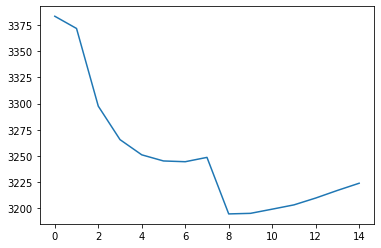

In [88]:
import matplotlib.pyplot as plt
plt.plot(loss)

In [30]:
model_file = open('./model_time_steps/model_epoch14', 'rb')

In [31]:
model_state_dict = torch.load(model_file)['model_state_dict']

In [32]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [71]:
from evaluate import evaluate
evaluate(model, validation_loader, device)

41
